In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Densité spectrale du bruit d'une machine à laver

In [2]:
from scipy.io.wavfile import read
samplerate, amplitude = read('data/machine_a_laver.wav')

In [3]:
print('Taux echantillonage :', samplerate)
N = len(amplitude)
print('Nb de points N :', N)
Delta_t = 1/samplerate
print('Delta t', Delta_t)
T = N*Delta_t
print('Durée mesure :', T)

Taux echantillonage : 44100
Nb de points N : 414380
Delta t 2.2675736961451248e-05
Durée mesure : 9.396371882086168


Text(0.5,0,'Temps (s)')

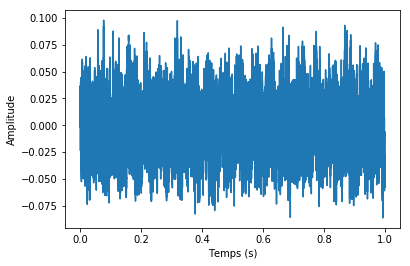

In [4]:
N_plot = samplerate
x_plot = np.arange(N_plot)*Delta_t
# NE PAS UTILISER np.linspace(0, 1, N_plot)
y_plot = amplitude[-N_plot:]
plt.plot(x_plot, y_plot)
plt.ylabel('Amplitude')
plt.xlabel('Temps (s)')

In [5]:
from scipy.signal import periodogram
freq, psd = periodogram(amplitude, samplerate, )

(1e-10, 0.001)

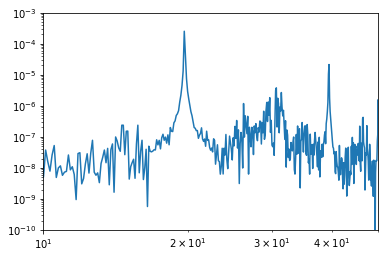

In [6]:
# Avec xlim
plt.loglog(freq, psd)
plt.xlim(10, 50)
plt.ylim(1E-10, 1E-3)

Text(0,0.5,'Densité de puissance ($V^2/Hz$)')

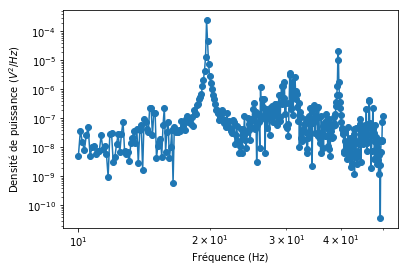

In [7]:
mask = (freq>10) & (freq<50)
plt.loglog(freq[mask], psd[mask], '-o')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité de puissance ($V^2/Hz$)')

In [8]:
i_max = psd[mask].argmax()
freq[mask][i_max]*60 # rpm

1181.3070128867223

In [9]:
delta_f = 1/T
print('Puissance moyenne :', amplitude.var())
print('Integrale DSP     :', np.sum(psd)*delta_f)

Puissance moyenne : 0.0006080771214276875
Integrale DSP     : 0.0006080771214276876


In [10]:
print( amplitude.std())


0.024659219805737723


In [11]:
mask = (freq>18) & (freq<21)
puissance_signal = np.sum(psd[mask])*delta_f
puissance_bruit = np.sum(psd[~mask])*delta_f
print('Puissance signal : ', puissance_signal)
print('Puissance bruit : ', puissance_bruit)
print('Rapport signal à bruit', puissance_signal/puissance_bruit)

Puissance signal :  3.5673495954542404e-05
Puissance bruit :  0.0005724036254731449
Rapport signal à bruit 0.062322274645019826


Puissance signal filtré:  4.610444813862146e-05


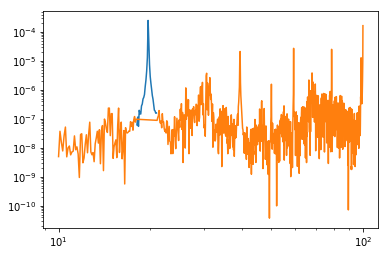

In [12]:
# Le bruit typique est de 1E-7
# On peut filtrer sur environ 100Hz pour avoir un rapport signal à bruit de 1
filtre = (freq>10) & (freq<100)
print('Puissance signal filtré: ', np.sum(psd[(~mask) & filtre])*delta_f)

plt.loglog(freq[(mask) & filtre], psd[(mask) & filtre])
plt.loglog(freq[(~mask) & filtre], psd[(~mask) & filtre])

## Filtre en Python

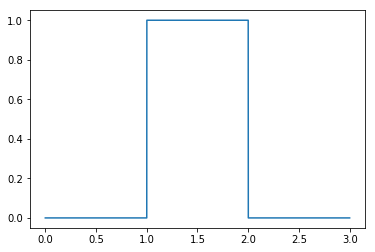

In [13]:
samplerate = 44100
signal = np.zeros(samplerate*3)
signal[samplerate:(samplerate*2)] = 1
x = np.arange(samplerate*3)*Delta_t
plt.plot(x, signal)

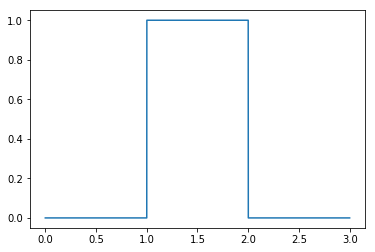

In [14]:
import numpy as np
signal_tilde = np.fft.rfft(signal)
signal_2 = np.fft.irfft(signal_tilde)
plt.plot(x, signal_2)

In [15]:
freqs = np.fft.rfftfreq(len(signal), Delta_t)
freqs[0] # 0
freqs[1] # 1/T soit 0.333
freqs[2] # 2/T soit 0.666
len(freqs) # environ N/2
freqs[-1] # samplerate/2 soit 22050

22050.0

In [16]:
def passe_bas(signal, f_c, samplerate=44100):
    signal_tilde = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), 1/samplerate)
    H = 1/(1+1J*(freqs/f_c))
    signal_2 = np.fft.irfft(H*signal_tilde)
    return signal_2

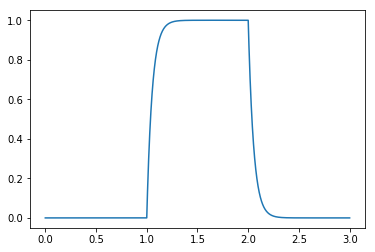

In [17]:
plt.plot(x, passe_bas(signal_2, 3))

In [18]:
def passe_haut(signal, f_c, samplerate=44100):
    signal_tilde = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), 1/samplerate)
    H = 1J*(freqs/f_c)/(1+1J*(freqs/f_c))
    signal_2 = np.fft.irfft(H*signal_tilde)
    return signal_2

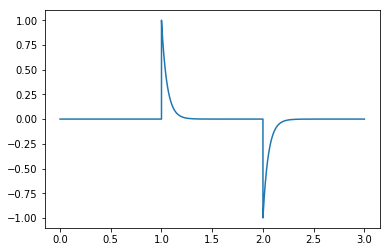

In [19]:
plt.plot(x, passe_haut(signal_2, 3))

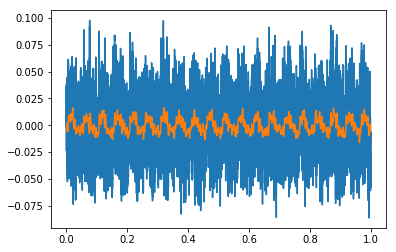

In [20]:
samplerate, amplitude = read('data/machine_a_laver.wav')
Delta_t = 1/samplerate
N_plot = samplerate
x_plot = np.arange(N_plot)*Delta_t
plt.plot(x_plot, amplitude[-N_plot:])
plt.plot(x_plot, passe_bas(amplitude[-N_plot:], 30))

## Onde gravitationnelle

In [21]:
from readligo import loaddata
filename_H1 = 'data/H-H1_LOSC_4_V1-1126259446-32.hdf5'
filename_L1 = 'data/L-L1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = loaddata(filename_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = loaddata(filename_L1, 'L1')

/home/pierre/sources/anaconda3/envs/enseignement/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
Delta_t = time_H1[1] - time_H1[0]
samplerate = 1/Delta_t
samplerate
N = len(strain_H1)
T = N*Delta_t
T
time_H1[0]

1126259446.0

In [23]:
t_detection = time_H1[N//2]
print('instant detection', t_detection)

instant detection 1126259462.0


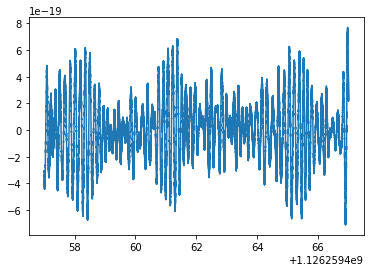

In [24]:
mask = np.abs(time_H1 - t_detection)<5
plt.plot(time_H1[mask], strain_H1[mask])

In [25]:
from scipy.signal import welch
f, psd = welch(strain_H1, samplerate, nperseg=samplerate)
f_periodogram, psd_periodogram = periodogram(strain_H1, samplerate)

Text(0,0.5,'DSP ($Hz^-1$)')

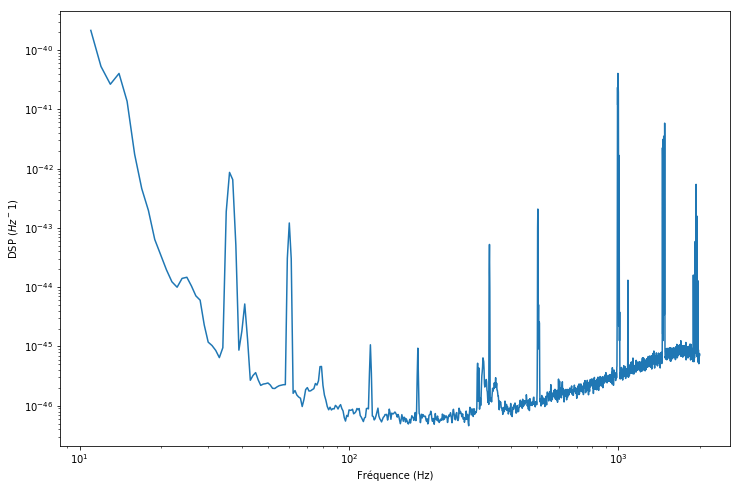

In [26]:
mask = (f>10) & (f<2E3)
plt.figure(figsize=(12,8))
plt.loglog(f[mask], psd[mask])
mask_periodogram = (f_periodogram>10) & (f_periodogram<2E3)
#plt.loglog(f_periodogram[mask_periodogram], psd_periodogram[mask_periodogram])

plt.xlabel('Fréquence (Hz)')
plt.ylabel('DSP ($Hz^-1$)')

In [27]:
from scipy.interpolate import interp1d    

def whiten(strain, dt):
    freqs_welch, psd_welch = welch(strain, fs=1/dt, nperseg=int(1/dt))
    interp_psd = interp1d(freqs_welch, psd_welch)

    strain_tilde = np.fft.rfft(strain)
    N = len(strain)
    freqs = np.fft.rfftfreq(N, dt)

    gain = 1 / np.sqrt(interp_psd(freqs))
    gain = gain/gain.max()
    white_strain_tilde = strain_tilde * gain
    white_strain = np.fft.irfft(white_strain_tilde)
    return white_strain

In [28]:
strain_H1_whiten = whiten(strain_H1, dt=1/samplerate)
y = passe_bas(strain_H1_whiten, 300, samplerate=samplerate)
y = passe_bas(y, 300, samplerate=samplerate)
strain_H1_whiten_filtre = passe_haut(y, 20, samplerate=samplerate)

strain_L1_whiten = whiten(strain_L1, dt=1/samplerate)
y = passe_bas(strain_L1_whiten, 300, samplerate=samplerate)
y = passe_bas(y, 300, samplerate=samplerate)
strain_L1_whiten_filtre = passe_haut(y, 20, samplerate=samplerate)

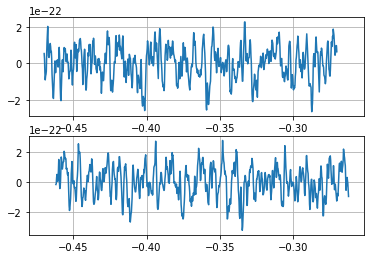

In [29]:
plt.subplot(2, 1, 1)
t_detection_H1 = time_H1[N//2] + 0.37
mask = np.abs(time_H1 - t_detection)<0.1
plt.plot(time_H1[mask]- t_detection_H1, strain_H1_whiten_filtre[mask])
plt.grid()

t_detection_L1 = t_detection_H1 - 0.008
plt.subplot(2, 1, 2, sharex=plt.gca())
plt.plot(time_L1[mask]- t_detection_L1, -strain_L1_whiten_filtre[mask])
plt.grid()

In [33]:
def correlation(signal1, signal2, delta_N=0, fc=10, samplerate=samplerate):
    if delta_N==0:
        correlation = signal1 * signal2
    else:
        if delta_N<0:
            delta_N = -delta_N
            signal1, signal2 = signal2, signal1
        correlation = signal1[delta_N:] * signal2[:-delta_N]
    correlation_filtree = passe_bas(correlation, fc, samplerate)
    return correlation_filtree

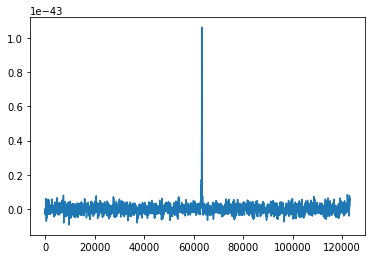

In [34]:
correlation_H1_L1 = correlation(strain_H1_whiten_filtre, -strain_L1_whiten_filtre, 32)
plt.plot(correlation_H1_L1[4000:-4000])

In [35]:
liste_delta_N = np.arange(-70, 70)

samplerate = int(samplerate)
out = []
for delta_N in liste_delta_N:
    tmp = correlation(strain_H1_whiten_filtre, -strain_L1_whiten_filtre, delta_N)
    n_center = len(tmp)//2
    out.append(tmp[(n_center-5*samplerate):(n_center+5*samplerate)])
out = np.array(out)

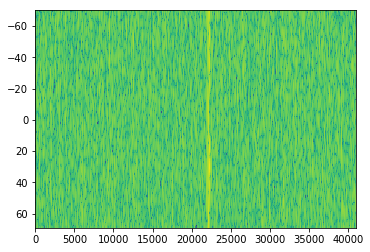

In [36]:
plt.imshow(np.log(abs(out)), aspect=200, extent=(0, out.shape[1], liste_delta_N[-1], liste_delta_N[0]))